## **Deep Learning with Python**

### **Project: Clickbait phenomenon on US Youtube Videos**
#### Group members: Hsun-hui Lin, Wei-Ling Liao

Project Description: The dataset **Trending Youtube Video Statistics** was found on kaggle (URL:https://www.kaggle.com/datasets/datasnaek/youtube-new). This dataset includes several months (and counting) of data on daily trending YouTube videos. Many countries were included in this dataset and we chose **US** as our research target. Data includes the video title, channel title, publish time, tags, views, likes and dislikes, description, and comment count.

We’ve all seen it, and probably most of us have fallen for it – those headlines that scream that “You’ll never guess what XXX did” or “This will blow your mind”. In the online industry, these headlines are called **Clickbait**, a baiting headline designed to trigger an emotional response that urges you to click through to see what’s next. 

In this project, we are interested in whether there is Clickbait phenomenon between video title and its view count and we want to figure out whether the model could learn the pattern of catchy titles and subsequently predict the view counts. To achieve our goal, we use the pre-trained model *Glove* and did some experiments to find the best model with different combinations of building layers. At the end, we use the trained-model to predict sentences that are considered to be clickbait titles from online resources and give a observable conclusion on the basis of the result. 


## Part 1
### 1.1 Import libraries

In [47]:
import sys
sys.path.insert(0,'/export/home/wei-ling.liao/.local/lib/python3.10/site-packages')

In [48]:
!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable


In [49]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re

In [50]:
from keras import models,layers
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

### 1.2 Feature Selection

In terms of regression problem of view counts, the dataset provides some extraneous features that we do not believe are needed for training a proper model. We decided to only consider *title* and *views* columns to reduce feature complexity.

In [51]:
df = pd.read_csv("/compLing/students/courses/deepLearning/finalProject23/wei-ling.liao/USvideos.csv")
df.head()

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [52]:
# only title and views columns are needed
df = df[["title", "views"]]
df.head()

,title,views
0,WE WANT TO TALK ABOUT OUR MARRIAGE,748374
1,The Trump Presidency: Last Week Tonight with J...,2418783
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",3191434
3,Nickelback Lyrics: Real or Fake?,343168
4,I Dare You: GOING BALD!?,2095731


### 1.3 Data Inspection

In [53]:
len(df) # there are 40949 rows in total

40949

In [54]:
df.shape # check the shape of df

(40949, 2)

In [55]:
print(df.isna().sum()) # check if there is any NA value in dataframe

title    0
views    0
dtype: int64


In [56]:
print("Least view count is {min}, and the most has {max} views.".format(min=df.views.min(), max=df.views.max()))

print("The mean: ", df.views.mean())
print("The median: ", df.views.median())
print("The std: ", df.views.std())

Least view count is 549, and the most has 225211923 views.
The mean:  2360784.6382573447
The median:  681861.0
The std:  7394113.75970394


### 1.4 Data Transformation: Log transformation & Normalization

We have seen that there is a huge variance in the view count; therefore, it is necessary to reduce the skewness for further steps. The skewness before log-transformation was 12.24, while the value is reduced to -0.4 after log algorithm. Furthermore, we applied normalization to change the values of views_log column in the dataset to a common scale, without distorting differences in the ranges of values. This process helps to save the training time and the memory used to store the data.

In [57]:
df["views_log"] = round(np.log1p(df["views"]),2) # applied log-transformation 
df.head()

,title,views,views_log
0,WE WANT TO TALK ABOUT OUR MARRIAGE,748374,13.53
1,The Trump Presidency: Last Week Tonight with J...,2418783,14.70
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",3191434,14.98
3,Nickelback Lyrics: Real or Fake?,343168,12.75
4,I Dare You: GOING BALD!?,2095731,14.56


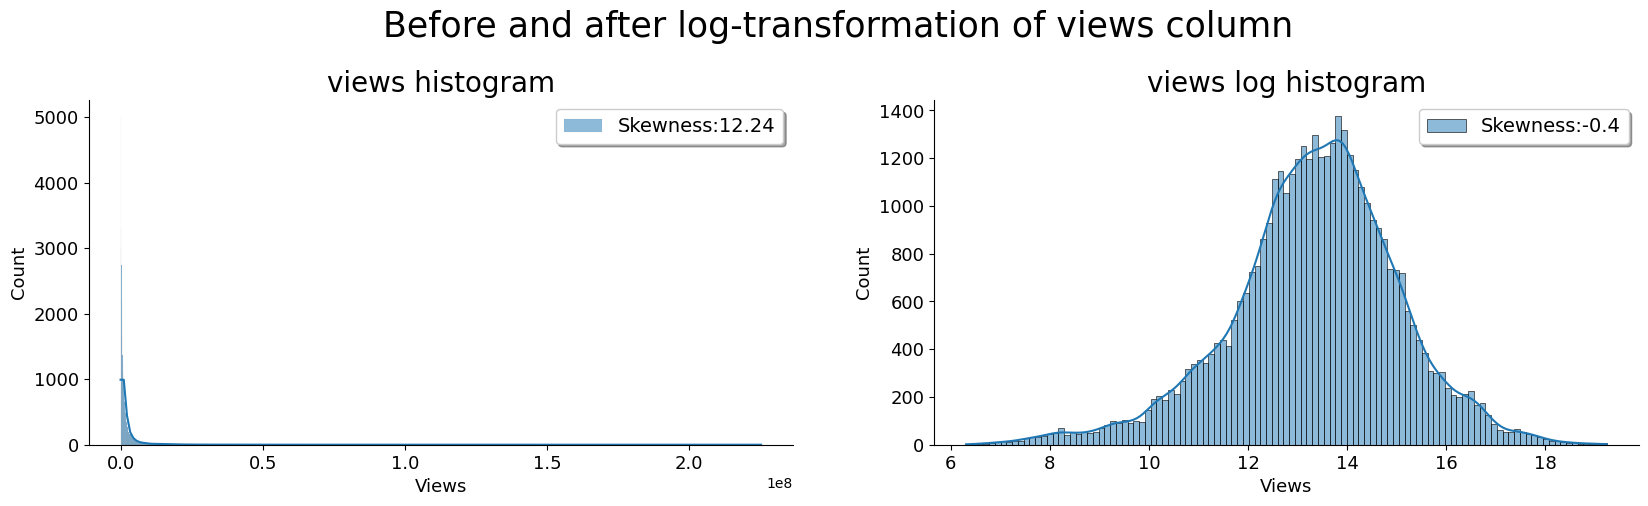

In [58]:
# Visualize the views count after log algorithm
plt.figure(figsize = (20,5))
plt.subplots_adjust(top=0.8)
plt.suptitle("Before and after log-transformation of views column",fontsize=25)
ax = plt.subplot(1,2,1)
sns.histplot(df["views"],kde=True,label="Skewness:"+str(round(df["views"].skew(),2)))
plt.legend(fontsize=14,shadow=True,fancybox=True, frameon=True)
ax.set_title("views"+' histogram',fontsize=20)
plt.tick_params(labelsize=13)
plt.xlabel("Views",fontsize=13)
plt.ylabel("Count",fontsize=13)

ax = plt.subplot(1,2,2)
sns.histplot(np.log1p(df["views"]),kde=True,label="Skewness:"+str(round(np.log1p(df["views"]).skew(),2)))
plt.legend(fontsize=14,shadow=True,fancybox=True, frameon=True)
ax.set_title("views"+' log histogram',fontsize=20)
plt.tick_params(labelsize=13)
plt.xlabel("Views",fontsize=13)
plt.ylabel("Count",fontsize=13)
sns.despine()
plt.show()

In [59]:
# Normalize the views_log between 0 and 1
def normalize(col):
    min_value = col.min()
    max_value = col.max()
    for i in range(len(col)):
        col[i] = (col[i] - min_value)/(max_value - min_value)
    return col

In [60]:
df["views_norm"] = df["views_log"]
normalize(df["views_norm"])
df

/tmp/ipykernel_44658/554750883.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  col[i] = (col[i] - min_value)/(max_value - min_value)


,title,views,views_log,views_norm
0,WE WANT TO TALK ABOUT OUR MARRIAGE,748374,13.53,0.558824
1,The Trump Presidency: Last Week Tonight with J...,2418783,14.70,0.649381
2,"Racist Superman | Rudy Mancuso, King Bach & Le...",3191434,14.98,0.671053
3,Nickelback Lyrics: Real or Fake?,343168,12.75,0.498452
4,I Dare You: GOING BALD!?,2095731,14.56,0.638545
...,...,...,...,...
40944,The Cat Who Caught the Laser,1685609,14.34,0.621517
40945,True Facts : Ant Mutualism,1064798,13.88,0.585913
40946,I GAVE SAFIYA NYGAARD A PERFECT HAIR MAKEOVER ...,1066451,13.88,0.585913
40947,How Black Panther Should Have Ended,5660813,15.55,0.715170


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


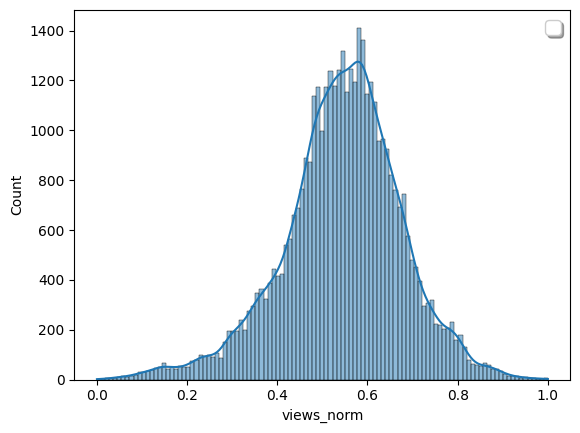

In [61]:
# plot the views_norm 
sns.histplot(df.views_norm,kde=True)
plt.legend(fontsize=14,shadow=True,fancybox=True, frameon=True)

In [62]:
min_length = min([len(title.split()) for title in df["title"]])
print("Length of the shortest title: ", min_length)

max_length = max([len(title.split()) for title in df["title"]])
print("Length of the longest title: ", max_length)

Length of the shortest title:  1
Length of the longest title:  23


### 1.5 Data Preprocessing & Data Splitting

In [63]:
df.title = df.title.replace('\n','')
df.title = df.title.str.lower() # lowercase the text
print("Videos extractd: ", df.title.nunique()) # nunique() returns the number of unique values for each column
print("Differences in views_norm: ", df.views_norm.nunique())
df

Videos extractd:  6440
Differences in views_norm:  1176


,title,views,views_log,views_norm
0,we want to talk about our marriage,748374,13.53,0.558824
1,the trump presidency: last week tonight with j...,2418783,14.70,0.649381
2,"racist superman | rudy mancuso, king bach & le...",3191434,14.98,0.671053
3,nickelback lyrics: real or fake?,343168,12.75,0.498452
4,i dare you: going bald!?,2095731,14.56,0.638545
...,...,...,...,...
40944,the cat who caught the laser,1685609,14.34,0.621517
40945,true facts : ant mutualism,1064798,13.88,0.585913
40946,i gave safiya nygaard a perfect hair makeover ...,1066451,13.88,0.585913
40947,how black panther should have ended,5660813,15.55,0.715170


In [64]:
# although there are 40949 rows but only 6440 unique titles; therefore, we decided to groupby the data based on the titles
# and calculate the means of views_norm
df = df.groupby(['title']).mean().reset_index()
df

,title,views,views_log,views_norm
0,#184 making a pcb using easyeda. // review,3.237000e+03,8.080000,0.136997
1,"#23 feed the homeless | one list, one life",4.025333e+04,10.600000,0.332043
2,#57: am and ssb explained,3.489500e+03,8.157500,0.142995
3,"#abovethenoise feat. serena williams, neymar j...",2.152261e+06,14.580000,0.640093
4,#boogiedown contest winners announced,3.787939e+06,15.128889,0.682577
...,...,...,...,...
6435,힐링쿠킹♥ 빙글빙글 회오리젤리 만들기! - ari kitchen(아리키친),2.801898e+05,12.537500,0.482005
6436,"🍒 april favs 🍒 (music, clothes, life)",1.452812e+05,11.883750,0.431405
6437,🍫달콤 쌉사름~ 리얼 초콜릿 우유 만들기 real chocolate milk | 한세,1.563886e+05,11.928571,0.434874
6438,🎃 how to make pumpkin pie mistakes,1.533730e+05,11.905000,0.433050


In [65]:
# we defined a function to remove emojis and non-English languages (it's not perfect but it still helps as preprocessing)
# Reference : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [66]:
df.title = df.title.apply(lambda text: remove_emoji(text))
df

,title,views,views_log,views_norm
0,#184 making a pcb using easyeda. // review,3.237000e+03,8.080000,0.136997
1,"#23 feed the homeless | one list, one life",4.025333e+04,10.600000,0.332043
2,#57: am and ssb explained,3.489500e+03,8.157500,0.142995
3,"#abovethenoise feat. serena williams, neymar j...",2.152261e+06,14.580000,0.640093
4,#boogiedown contest winners announced,3.787939e+06,15.128889,0.682577
...,...,...,...,...
6435,! - ari kitchen(),2.801898e+05,12.537500,0.482005
6436,"april favs (music, clothes, life)",1.452812e+05,11.883750,0.431405
6437,~ real chocolate milk |,1.563886e+05,11.928571,0.434874
6438,how to make pumpkin pie mistakes,1.533730e+05,11.905000,0.433050


**Most viewed videos:** 
Here we inspected the most_viewed videos in this dataset and found out that most of them are music videos of famous singers or bands, such as Childish Gambino, TWICE etc. It is good to know the type of the extreme values so as to infer a more probable outcome at the end.

In [67]:
most_viewed = df.sort_values(by=['views_norm'], ascending=False).head(10)
most_viewed

,title,views,views_log,views_norm
1102,childish gambino - this is america (official v...,1.503396e+08,18.724800,0.960898
878,bts () 'fake love' official mv,9.165631e+07,18.293571,0.927521
6371,youtube rewind: the shape of 2017 | #youtubere...,9.760013e+07,18.268750,0.925600
3649,marvel studios' avengers: infinity war officia...,7.438727e+07,18.092222,0.911937
3582,maluma - el préstamo (official video),6.800549e+07,18.019091,0.906276
566,ariana grande - no tears left to cry,7.646457e+07,18.016500,0.906076
5802,twice what is love? m/v,5.530861e+07,17.813571,0.890369
5876,venom - official trailer (hd),5.279743e+07,17.769474,0.886956
1000,"cardi b, bad bunny & j balvin - i like it [off...",5.603490e+07,17.686875,0.880563
662,"becky g, natti natasha - sin pijama (official ...",5.914856e+07,17.673500,0.879528


In [68]:
least_viewed = df.sort_values(by=['views_norm'], ascending=True).head(10)
least_viewed

,title,views,views_log,views_norm
74,"1 dead, others injured after ky. school shooting",554.000000,6.320000,0.000774
1192,coach taggart monday presser ahead of arizona,695.500000,6.545000,0.018189
580,artwork forge,705.333333,6.556667,0.019092
4417,"raw: 3 south carolina deputies, 1 officer shot",748.000000,6.620000,0.023994
2555,huffy metaloid bicycle commercial 1997,773.000000,6.650000,0.026316
632,bannon arrives to testify on capitol hill,821.666667,6.713333,0.031218
4111,ojo commuter scooter®- light electric vehicle ...,853.000000,6.745000,0.033669
5858,ur eeoc complainants press conference (5pm jan...,943.250000,6.852500,0.041989
3065,john thrasher: jimbo's here forever,983.666667,6.893333,0.045150
2028,gas mask scene | kong: skull island (2017),1017.666667,6.926667,0.047730


In [71]:
# turn dataframe into list for tokenization
titles = df['title'].values.tolist()
views = df['views_norm'].values.tolist()

# A commonly used ratio is 80:20 for data splitting - 80% of the dataset as training data, 10% as validation data and the rest as testing data. 
training_samples = round(len(titles) * 0.8)
val_samples = round(len(titles) * 0.1)
test_samples = len(titles) - training_samples - val_samples

In [72]:
tokenizer = Tokenizer(num_words=10000,  filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(titles)  #list
sequences = tokenizer.texts_to_sequences(titles)
padded_data = pad_sequences(sequences, maxlen=max_length) #length of the longest title

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11007 unique tokens.


In [73]:
y = df.views_norm

In [74]:
# convert views to np array and check the shape of views_norm tensor
labels = np.asarray(y)

print('Shape of data tensor:', padded_data.shape)
print('Shape of views_norm tensor:', labels.shape) # one arbitrary value


Shape of data tensor: (6440, 23)
Shape of views_norm tensor: (6440,)


In [75]:
# shuffle data
indices = np.arange(padded_data.shape[0])
np.random.shuffle(indices)

In [76]:
padded_data = padded_data[indices]
views = labels[indices]

x_train = padded_data[:training_samples]
y_train = views[:training_samples]
x_val = padded_data[training_samples: training_samples + val_samples]
y_val = views[training_samples: training_samples + val_samples]
x_test = padded_data[training_samples + val_samples:]
y_test = views[training_samples + val_samples:]

In [77]:
x_train.shape

(5152, 23)

In [78]:
x_test.shape

(644, 23)

In [79]:
x_val.shape

(644, 23)

## Part 2
### 2.1 Build Glove Word Embeddings

GloVe is a word embedding technique that doesn’t only rely on local statistics but also global word statistics (word co-occurrence). GloVe assumes that you can derive relationships between words from a co-occurrence matrix. Here we take glove.6B.200d which was collected by wikepedia and English Gigaword 5th edition.

In [80]:
#define path to embeddings
glove_dir = '/compLing/students/courses/deepLearning/glove.6B/glove.6B.200d.txt'

# read embeddings and go through each line in the file
embeddings_index = {}
f = open(glove_dir) # 200 dimensions
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))
print(coefs.shape)

Found 400000 word vectors.
(200,)


In [81]:
# build an embedding matrix that will be able to load into an Embedding layer
# each entry i contains the embedding_dim-dimensional vector for the word of index i in our reference word index (built during tokenization).
embedding_dim = 200
max_words = len(word_index)+1

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

### 2.2 Model Setup, Training and Testing

**First model: Regression Model - ReLU (Baseline for Neural Network)**

We created an embedding matrix for these words using vectors from the loaded Glove embedding and passed this matrix as weights to the embedding layer of our sequential model. Next, we added a flatten layer and a dense layer with Rectified Linear Unit (ReLU) as the activation function. ReLU is defined as the maximum between zero and the input. This forces non-linearity on the output of neurons in a neural network. For the final layer, we added another dense layer with sigmoid as the activation function.

In [121]:
# a sequential model is instantiated 
model = Sequential()

# define input layer where embeddings are fed in
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_length, weights=[embedding_matrix], trainable=False))

# add a flatten layer
model.add(Flatten())

# add a dense layer with relu activation function
model.add(layers.Dense(32, activation='relu'))

# define outpuy layer with sigmoid activation function because it's regression problem
# parameter 1 is because there is only one arbitrary value each interation
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 23, 200)           2201600   
                                                                 
 flatten_2 (Flatten)         (None, 4600)              0         
                                                                 
 dense_21 (Dense)            (None, 32)                147232    
                                                                 
 dense_22 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,348,865
Trainable params: 147,265
Non-trainable params: 2,201,600
_________________________________________________________________


In [122]:
# Load the GloVe embeddings in the model
model.layers[0].set_weights([embedding_matrix])

# freeze the embedding layers
model.layers[0].trainable = False

In [123]:
# train and evaluate the model
model.compile(optimizer='rmsprop',
              loss='mse', # mean square error is a common option for regression probelm
              metrics=['mae']) # mean absolute error is calculated during training and evaluation, but are not used to optimize the model, it's also common for regression problem

history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
161/161 [==============================] - 1s 3ms/step - loss: 0.0189 - mae: 0.1066 - val_loss: 0.0186 - val_mae: 0.1034
Epoch 2/10
161/161 [==============================] - 0s 2ms/step - loss: 0.0124 - mae: 0.0856 - val_loss: 0.0193 - val_mae: 0.1052
Epoch 3/10
161/161 [==============================] - 0s 2ms/step - loss: 0.0084 - mae: 0.0691 - val_loss: 0.0204 - val_mae: 0.1102
Epoch 4/10
161/161 [==============================] - 0s 2ms/step - loss: 0.0056 - mae: 0.0555 - val_loss: 0.0225 - val_mae: 0.1142
Epoch 5/10
161/161 [==============================] - 0s 2ms/step - loss: 0.0039 - mae: 0.0456 - val_loss: 0.0220 - val_mae: 0.1152
Epoch 6/10
161/161 [==============================] - 0s 2ms/step - loss: 0.0028 - mae: 0.0388 - val_loss: 0.0229 - val_mae: 0.1192
Epoch 7/10
161/161 [==============================] - 0s 2ms/step - loss: 0.0021 - mae: 0.0338 - val_loss: 0.0228 - val_mae: 0.1180
Epoch 8/10
161/161 [==============================] - 0s 2ms/step - loss: 0.

In [124]:
model.evaluate(x_test,y_test)

21/21 [==============================] - 0s 1ms/step - loss: 0.0200 - mae: 0.1094


[0.01998577080667019, 0.10941171646118164]

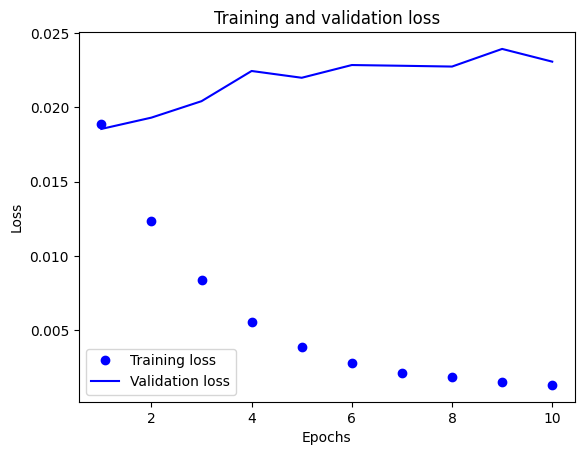

In [125]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 3. Experimentation

- **Second model** is constituted of an embedding layer, a LSTM layer, and a Dense layer, with a final output layer that uses a sigmoid activation function to predict a single continuous value.

In [126]:
# a sequential model is instantiated 
model2 = Sequential()

# define input layer where embeddings are fed in
model2.add(Embedding(max_words, embedding_dim, input_length=max_length))

# add a LSTM layer with 64 units
model2.add(LSTM(64))

# add a dense layer 
model2.add(layers.Dense(32, activation='relu'))

# define outpuy layer with sigmoid activation function because it's regression problem
# parameter 1 is because there is only one arbitrary value each interation
model2.add(Dense(1, activation='sigmoid'))
model2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 23, 200)           2201600   
                                                                 
 lstm_14 (LSTM)              (None, 64)                67840     
                                                                 
 dense_23 (Dense)            (None, 32)                2080      
                                                                 
 dense_24 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,271,553
Trainable params: 2,271,553
Non-trainable params: 0
_________________________________________________________________


In [127]:
# Load the GloVe embeddings in the model
model2.layers[0].set_weights([embedding_matrix])

# freeze the embedding layers
model2.layers[0].trainable = False

In [128]:
# train and evaluate the model
model2.compile(optimizer='rmsprop',
              loss='mse', 
              metrics=['mae'])

history2 = model2.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
161/161 [==============================] - 3s 13ms/step - loss: 0.0181 - mae: 0.1050 - val_loss: 0.0186 - val_mae: 0.1051
Epoch 2/10
161/161 [==============================] - 2s 11ms/step - loss: 0.0166 - mae: 0.1007 - val_loss: 0.0182 - val_mae: 0.1039
Epoch 3/10
161/161 [==============================] - 2s 11ms/step - loss: 0.0156 - mae: 0.0976 - val_loss: 0.0182 - val_mae: 0.1039
Epoch 4/10
161/161 [==============================] - 2s 11ms/step - loss: 0.0147 - mae: 0.0945 - val_loss: 0.0177 - val_mae: 0.1016
Epoch 5/10
161/161 [==============================] - 2s 12ms/step - loss: 0.0138 - mae: 0.0915 - val_loss: 0.0177 - val_mae: 0.1033
Epoch 6/10
161/161 [==============================] - 2s 11ms/step - loss: 0.0130 - mae: 0.0885 - val_loss: 0.0180 - val_mae: 0.1028
Epoch 7/10
161/161 [==============================] - 2s 11ms/step - loss: 0.0123 - mae: 0.0860 - val_loss: 0.0186 - val_mae: 0.1041
Epoch 8/10
161/161 [==============================] - 2s 11ms/step - 

In [129]:
model2.evaluate(x_test,y_test)

21/21 [==============================] - 0s 6ms/step - loss: 0.0173 - mae: 0.1020


[0.017323287203907967, 0.10200534760951996]

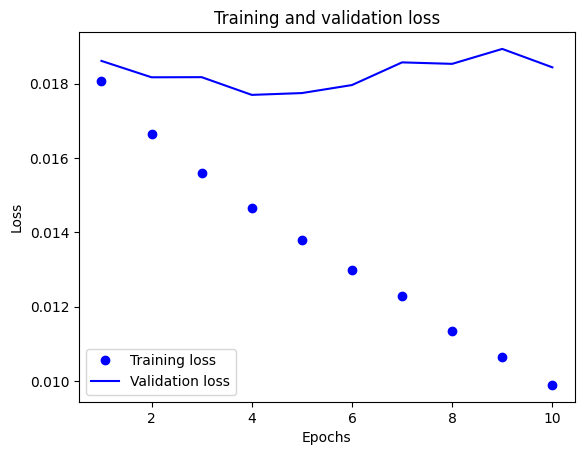

In [130]:
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- **Third Model** includes an embedding layer, two LSTM layers, and a final output layer that uses a sigmoid activation function.

In [136]:
# a sequential model is instantiated 
model3 = Sequential()

# define input layer where embeddings are fed in
model3.add(Embedding(max_words, embedding_dim, input_length=max_length))

# add two LSTM layers with 64 units
model3.add(LSTM(64, return_sequences = True))
model3.add(LSTM(32))

# define outpuy layer with sigmoid activation function because it's regression problem
# parameter 1 is because there is only one arbitrary value each interation
model3.add(Dense(1, activation='sigmoid'))
model3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 23, 200)           2201600   
                                                                 
 lstm_17 (LSTM)              (None, 23, 64)            67840     
                                                                 
 lstm_18 (LSTM)              (None, 32)                12416     
                                                                 
 dense_26 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,281,889
Trainable params: 2,281,889
Non-trainable params: 0
_________________________________________________________________


In [137]:
# Load the GloVe embeddings in the model
model3.layers[0].set_weights([embedding_matrix])

# freeze the embedding layers
model3.layers[0].trainable = False

In [138]:
# train and evaluate the model
model3.compile(optimizer='rmsprop',
              loss='mse', 
              metrics=['mae'])

history3 = model3.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(x_val, y_val))

Epoch 1/10
161/161 [==============================] - 5s 20ms/step - loss: 0.0183 - mae: 0.1052 - val_loss: 0.0187 - val_mae: 0.1069
Epoch 2/10
161/161 [==============================] - 3s 17ms/step - loss: 0.0172 - mae: 0.1024 - val_loss: 0.0185 - val_mae: 0.1065
Epoch 3/10
161/161 [==============================] - 3s 16ms/step - loss: 0.0167 - mae: 0.1011 - val_loss: 0.0183 - val_mae: 0.1060
Epoch 4/10
161/161 [==============================] - 3s 17ms/step - loss: 0.0163 - mae: 0.0998 - val_loss: 0.0185 - val_mae: 0.1056
Epoch 5/10
161/161 [==============================] - 3s 17ms/step - loss: 0.0159 - mae: 0.0985 - val_loss: 0.0186 - val_mae: 0.1059
Epoch 6/10
161/161 [==============================] - 3s 17ms/step - loss: 0.0155 - mae: 0.0974 - val_loss: 0.0185 - val_mae: 0.1051
Epoch 7/10
161/161 [==============================] - 3s 18ms/step - loss: 0.0152 - mae: 0.0962 - val_loss: 0.0186 - val_mae: 0.1057
Epoch 8/10
161/161 [==============================] - 3s 18ms/step - 

In [139]:
model3.evaluate(x_test,y_test)

21/21 [==============================] - 0s 8ms/step - loss: 0.0176 - mae: 0.1016


[0.01758233830332756, 0.10160604864358902]

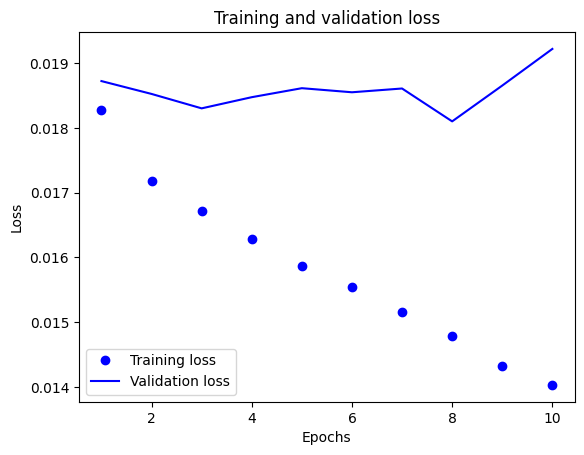

In [140]:
loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- **The fourth model** contains an Embedding layer, two LSTM layers, a Dense layer, and a final output layer with a sigmoid activation function

In [141]:
model4 = Sequential()

# define input layer where embeddings are fed in
model4.add(Embedding(max_words, embedding_dim, input_length=max_length))


# add the combination layers of model 2 and 3
model4.add(LSTM(64, return_sequences=True))
model4.add(LSTM(32))
model4.add(layers.Dense(32, activation='relu'))
model4.add(Dense(1, activation='sigmoid'))
model4.summary()

model4.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history4 = model4.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 23, 200)           2201600   
                                                                 
 lstm_19 (LSTM)              (None, 23, 64)            67840     
                                                                 
 lstm_20 (LSTM)              (None, 32)                12416     
                                                                 
 dense_27 (Dense)            (None, 32)                1056      
                                                                 
 dense_28 (Dense)            (None, 1)                 33        
                                                                 
Total params: 2,282,945
Trainable params: 2,282,945
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
161/161 [=======================

In [146]:
model4.evaluate(x_test,y_test)

21/21 [==============================] - 0s 7ms/step - loss: 0.0174 - mae: 0.1012


[0.017379922792315483, 0.10123017430305481]

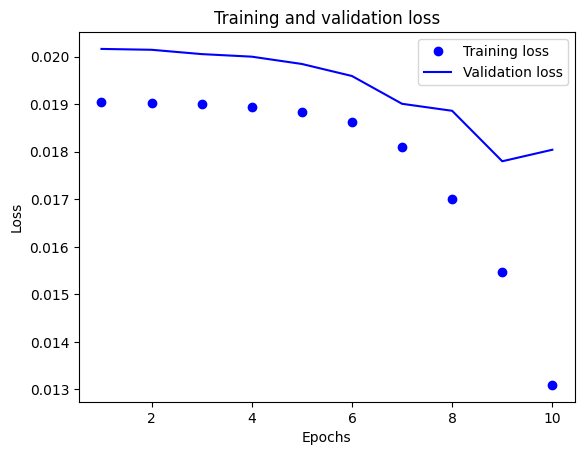

In [142]:
loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- **The fifth model** contains an Embedding layer, two LSTM layers, a Dense layer, and a final output layer with a sigmoid activation function, while all the hidden layers have only 8 units each layer.

In [143]:
model5 = Sequential()

# define input layer where embeddings are fed in
model5.add(Embedding(max_words, embedding_dim, input_length=max_length))


# add the same type of layers as model4 but with 8 units
model5.add(LSTM(8, return_sequences=True))
model5.add(LSTM(8))
model5.add(layers.Dense(8, activation='relu'))
model5.add(Dense(1, activation='sigmoid'))
model5.summary()

model5.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

history5 = model5.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val))

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 23, 200)           2201600   
                                                                 
 lstm_21 (LSTM)              (None, 23, 8)             6688      
                                                                 
 lstm_22 (LSTM)              (None, 8)                 544       
                                                                 
 dense_29 (Dense)            (None, 8)                 72        
                                                                 
 dense_30 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,208,913
Trainable params: 2,208,913
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
161/161 [=======================

In [145]:
model5.evaluate(x_test,y_test)

21/21 [==============================] - 0s 4ms/step - loss: 0.0177 - mae: 0.1017


[0.017667820677161217, 0.10170033574104309]

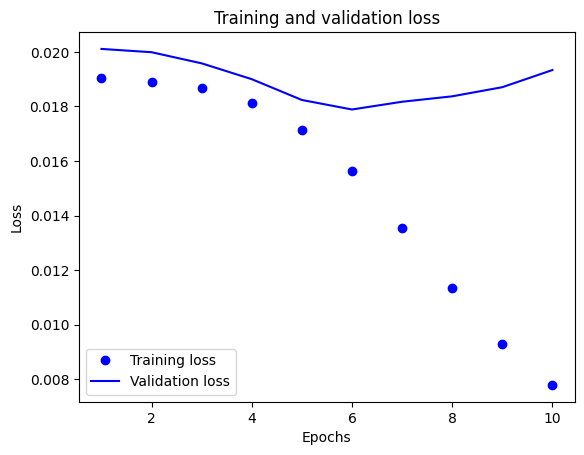

In [144]:
loss = history5.history['loss']
val_loss = history5.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### 4. Prediction & Conclusion

In [158]:
test = ["Before You Get Married, Read This",
        "12 Party Tricks I Wished I Learned When I Was Younger",
        "We Surveyed 450 Newlyweds. What We Found Shocked Us",
        "I Ate Nothing But Meat For 3 Months, And This Is What Happened To My Body",
        "Only 5% Of People Can Figure Out This Riddle.",
        "Official music video"]
list(map(lambda x: x.lower(), test))

['before you get married, read this',
 '12 party tricks i wished i learned when i was younger',
 'we surveyed 450 newlyweds. what we found shocked us',
 'i ate nothing but meat for 3 months, and this is what happened to my body',
 'only 5% of people can figure out this riddle.',
 'official music video']

In [156]:
tokenizer = Tokenizer(num_words=10000,  filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(test)  #list
sequences_test = tokenizer.texts_to_sequences(test)
padded_data_test = pad_sequences(sequences_test, maxlen=max_length) #length of the longest title

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 47 unique tokens.


In [157]:
model4.predict(padded_data_test)

1/1 [==============================] - 0s 24ms/step


array([[0.5986377 ],
       [0.5655294 ],
       [0.5312588 ],
       [0.50532585],
       [0.56203085],
       [0.47711912]], dtype=float32)

**Conclusion:** After five experimentations, I would conclude that the fourth model seems to have slightly better result than the others, though it is obvious that all of them have problem of overfitting. 

We made a small test on our model by giving it online catchy titles and tested if the model can predict the (normalized) views count based on the given data. The answer is *No*. From the data inspection, we already knew that most of the the most_viewed videos are music videos from famous singers or bands, however, our model couldn't generate a higher value for title such as *"Official music video"*. In this case, we would argue that clickbait phenomenon is not obvious between title and views count because many other factors should also considered when investigating clickbait phenomenon, for example, "Is the image relevant? Is it of good quality? Does it have an emotional appeal?". Moreover, selection of glove pre-trained model can be experimented , for example (1) the dimensions or (2) would the pre-trained model with information from general web crawl perform better than for data from wikipedia in this case? All in all, though some improvements could be done to achieve better performance, the Youtube videos was a great opportunity to explore data with deep learning methods.